In [1]:

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split, KFold

import sys
sys.path.append('../DataLoader')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch()
print(fabric.device)

Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0


In [3]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
# dropout = 0.6990787087509548

k_folds = 5

In [4]:
dataset = SunImageDataset(csv_file="D:\\New folder (2)\\dataset.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size]
k_fold_2_indices = indices[fold_size:2*fold_size]
k_fold_3_indices = indices[2*fold_size:3*fold_size]
k_fold_4_indices = indices[3*fold_size:4*fold_size]
k_fold_5_indices = indices[4*fold_size:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]



400
400
400
400
400


In [5]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()
        
        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)
        
        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )
        
        
        # Fully connected layers
        self.fc = nn.Sequential(
            # nn.LeakyReLU(),
            nn.Linear(hidden_size*10, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()
        )
    
    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """
        
        batch_size = images.shape[0]
        
        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, -1)
        
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# model, optimizer = fabric.setup(model, optimizer)
model.train()

GmiSwinTransformer(
  (bn): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pretrained_model): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (layers): Sequential(
      (0): SwinTransformerStage(
        (downsample): Identity()
        (blocks): Sequential(
          (0): SwinTransformerBlock(
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path1): Identity()
            (norm2): LayerNorm((128,), eps=1e-05, elementwi

In [6]:
torch.cuda.empty_cache()

In [ ]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 5:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 5:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1
            
    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):  
            
    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if (tp > 0 and tn > 0) else 0
    return tss
    
def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    
    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return accuracy, precision, recall, f1





FOLD 1
--------------------------------


Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 1, Index: 0, Loss: 4.1873
Epoch: 1, Index: 1, Loss: 19.5254
Epoch: 1, Index: 2, Loss: 6.1440
Epoch: 1, Index: 3, Loss: 8.6639
Epoch: 1, Index: 4, Loss: 2.6539
Epoch: 1, Index: 5, Loss: 3.2553
Epoch: 1, Index: 6, Loss: 6.0870
Epoch: 1, Index: 7, Loss: 4.8735
Epoch: 1, Index: 8, Loss: 1.2123
Epoch: 1, Index: 9, Loss: 2.1052
Epoch: 1, Index: 10, Loss: 0.5993
Epoch: 1, Index: 11, Loss: 0.1962
Epoch: 1, Index: 12, Loss: 0.9216
Epoch: 1, Index: 13, Loss: 2.1197
Epoch: 1, Index: 14, Loss: 2.0162
Epoch: 1, Index: 15, Loss: 2.0538
Epoch: 1, Index: 16, Loss: 3.1388
Epoch: 1, Index: 17, Loss: 1.5171
Epoch: 1, Index: 18, Loss: 1.6811
Epoch: 1, Index: 19, Loss: 3.8057
Epoch: 1, Index: 20, Loss: 1.4771
Epoch: 1, Index: 21, Loss: 3.9986
Epoch: 1, Index: 22, Loss: 1.0838
Epoch: 1, Index: 23, Loss: 2.6180
Epoch: 1, Index: 24, Loss: 2.7115
Epoch: 1, Index: 25, Loss: 0.9319
Epoch: 1, Index: 26, Loss: 1.8686
Epoch: 1, Index: 27, Loss: 0.3673
Epoch: 1, Index: 28, Loss: 1.9875
Epoch: 1, Index: 29, Lo

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.8168370127677917
Validation Loss:  0.6567569375038147
Validation Loss:  2.2314453125
Validation Loss:  0.240478515625
Validation Loss:  1.656745433807373
Validation Loss:  0.40733712911605835
Validation Loss:  0.6275634765625
Validation Loss:  1.4107903242111206
Validation Loss:  0.47398465871810913
Validation Loss:  2.5943899154663086
Validation Loss:  1.6193363666534424
Validation Loss:  0.2569580078125
Validation Loss:  12.716341018676758
Validation Loss:  3.337890625
Validation Loss:  0.18587906658649445
Validation Loss:  1.3474928140640259
Validation Loss:  0.28527358174324036
Validation Loss:  4.996021747589111
Validation Loss:  2.6628215312957764
Validation Loss:  1.4058034420013428
Validation Loss:  1.5411376953125
Validation Loss:  0.2263605147600174
Validation Loss:  0.3818977475166321
Validation Loss:  4.230752944946289
Validation Loss:  1.4698486328125
Validation Loss:  0.21900109946727753
Validation Loss:  0.7497053146362305
Validation Loss:  1.89593052

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 2, Index: 0, Loss: 0.9625
Epoch: 2, Index: 1, Loss: 0.3191
Epoch: 2, Index: 2, Loss: 1.9922
Epoch: 2, Index: 3, Loss: 0.7071
Epoch: 2, Index: 4, Loss: 0.4371
Epoch: 2, Index: 5, Loss: 0.1857
Epoch: 2, Index: 6, Loss: 6.1992
Epoch: 2, Index: 7, Loss: 0.3773
Epoch: 2, Index: 8, Loss: 2.0564
Epoch: 2, Index: 9, Loss: 0.5940
Epoch: 2, Index: 10, Loss: 1.4508
Epoch: 2, Index: 11, Loss: 0.2817
Epoch: 2, Index: 12, Loss: 10.9082
Epoch: 2, Index: 13, Loss: 12.0514
Epoch: 2, Index: 14, Loss: 6.8950
Epoch: 2, Index: 15, Loss: 0.8193
Epoch: 2, Index: 16, Loss: 1.7968
Epoch: 2, Index: 17, Loss: 4.0326
Epoch: 2, Index: 18, Loss: 4.8429
Epoch: 2, Index: 19, Loss: 1.3994
Epoch: 2, Index: 20, Loss: 1.8281
Epoch: 2, Index: 21, Loss: 2.3060
Epoch: 2, Index: 22, Loss: 0.7090
Epoch: 2, Index: 23, Loss: 1.5310
Epoch: 2, Index: 24, Loss: 0.7381
Epoch: 2, Index: 25, Loss: 0.2532
Epoch: 2, Index: 26, Loss: 1.0529
Epoch: 2, Index: 27, Loss: 1.7485
Epoch: 2, Index: 28, Loss: 3.5991
Epoch: 2, Index: 29, L

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  1.1886087656021118
Validation Loss:  0.34033203125
Validation Loss:  0.12876677513122559
Validation Loss:  2.398601531982422
Validation Loss:  0.3982737362384796
Validation Loss:  1.45432448387146
Validation Loss:  13.759005546569824
Validation Loss:  1.144775390625
Validation Loss:  0.564610481262207
Validation Loss:  1.0284423828125
Validation Loss:  2.490795373916626
Validation Loss:  0.184814453125
Validation Loss:  2.909503221511841
Validation Loss:  0.1724853515625
Validation Loss:  1.9707149267196655
Validation Loss:  0.07267516106367111
Validation Loss:  3.989981174468994
Validation Loss:  15.66177749633789
Validation Loss:  0.4060264825820923
Validation Loss:  0.6402774453163147
Validation Loss:  0.1588134765625
Validation Loss:  3.1945557594299316
Validation Loss:  2.0894837379455566
Validation Loss:  1.3228204250335693
Validation Loss:  0.15692108869552612
Validation Loss:  0.3664143681526184
Validation Loss:  1.390625
Validation Loss:  1.1221923828125
Vali

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 3, Index: 0, Loss: 1.1203
Epoch: 3, Index: 1, Loss: 0.2769
Epoch: 3, Index: 2, Loss: 0.2774
Epoch: 3, Index: 3, Loss: 2.4661
Epoch: 3, Index: 4, Loss: 0.5596
Epoch: 3, Index: 5, Loss: 1.9917
Epoch: 3, Index: 6, Loss: 1.5859
Epoch: 3, Index: 7, Loss: 0.0341
Epoch: 3, Index: 8, Loss: 2.0457
Epoch: 3, Index: 9, Loss: 1.9798
Epoch: 3, Index: 10, Loss: 1.0551
Epoch: 3, Index: 11, Loss: 5.1272
Epoch: 3, Index: 12, Loss: 3.4749
Epoch: 3, Index: 13, Loss: 0.2507
Epoch: 3, Index: 14, Loss: 6.7450
Epoch: 3, Index: 15, Loss: 2.1977
Epoch: 3, Index: 16, Loss: 8.9423
Epoch: 3, Index: 17, Loss: 1.7169
Epoch: 3, Index: 18, Loss: 5.0112
Epoch: 3, Index: 19, Loss: 3.2895
Epoch: 3, Index: 20, Loss: 6.3160
Epoch: 3, Index: 21, Loss: 0.1207
Epoch: 3, Index: 22, Loss: 1.3590
Epoch: 3, Index: 23, Loss: 3.7002
Epoch: 3, Index: 24, Loss: 2.6206
Epoch: 3, Index: 25, Loss: 1.9113
Epoch: 3, Index: 26, Loss: 0.6627
Epoch: 3, Index: 27, Loss: 3.9251
Epoch: 3, Index: 28, Loss: 4.4127
Epoch: 3, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  1.0616947412490845
Validation Loss:  0.18685464560985565
Validation Loss:  0.10863588005304337
Validation Loss:  1.378265380859375
Validation Loss:  3.7655036449432373
Validation Loss:  0.25646108388900757
Validation Loss:  2.5022354125976562
Validation Loss:  1.5348292589187622
Validation Loss:  1.2690479755401611
Validation Loss:  1.9838464260101318
Validation Loss:  0.23243770003318787
Validation Loss:  0.8493146896362305
Validation Loss:  0.7985939979553223
Validation Loss:  0.0733642578125
Validation Loss:  0.4750392735004425
Validation Loss:  0.8928701877593994
Validation Loss:  4.302826881408691
Validation Loss:  0.2475402057170868
Validation Loss:  3.2459962368011475
Validation Loss:  3.908266305923462
Validation Loss:  0.9997023940086365
Validation Loss:  0.119140625
Validation Loss:  1.192101001739502
Validation Loss:  4.050048828125
Validation Loss:  0.103759765625
Validation Loss:  0.20895633101463318
Validation Loss:  0.36424335837364197
Validation Loss: 

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 4, Index: 0, Loss: 3.2899
Epoch: 4, Index: 1, Loss: 0.7881
Epoch: 4, Index: 2, Loss: 4.0422
Epoch: 4, Index: 3, Loss: 2.0764
Epoch: 4, Index: 4, Loss: 4.1672
Epoch: 4, Index: 5, Loss: 0.0755
Epoch: 4, Index: 6, Loss: 0.1373
Epoch: 4, Index: 7, Loss: 7.4708
Epoch: 4, Index: 8, Loss: 2.3960
Epoch: 4, Index: 9, Loss: 2.0571
Epoch: 4, Index: 10, Loss: 0.5505
Epoch: 4, Index: 11, Loss: 0.6203
Epoch: 4, Index: 12, Loss: 1.2888
Epoch: 4, Index: 13, Loss: 0.3351
Epoch: 4, Index: 14, Loss: 1.4936
Epoch: 4, Index: 15, Loss: 0.4883
Epoch: 4, Index: 16, Loss: 0.2960
Epoch: 4, Index: 17, Loss: 13.5623
Epoch: 4, Index: 18, Loss: 1.6178
Epoch: 4, Index: 19, Loss: 0.5125
Epoch: 4, Index: 20, Loss: 0.6002
Epoch: 4, Index: 21, Loss: 1.7108
Epoch: 4, Index: 22, Loss: 0.2285
Epoch: 4, Index: 23, Loss: 1.9412
Epoch: 4, Index: 24, Loss: 2.4753
Epoch: 4, Index: 25, Loss: 0.4940
Epoch: 4, Index: 26, Loss: 1.0774
Epoch: 4, Index: 27, Loss: 0.0160
Epoch: 4, Index: 28, Loss: 4.2083
Epoch: 4, Index: 29, Lo

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.7081329822540283
Validation Loss:  0.611328125
Validation Loss:  6.364250659942627
Validation Loss:  0.547899603843689
Validation Loss:  3.8035922050476074
Validation Loss:  0.6555109024047852
Validation Loss:  0.1910400390625
Validation Loss:  2.4405517578125
Validation Loss:  1.273172378540039
Validation Loss:  1.5523545742034912
Validation Loss:  0.7025324106216431
Validation Loss:  0.4923095703125
Validation Loss:  0.5114299058914185
Validation Loss:  0.6752970814704895
Validation Loss:  0.739501953125
Validation Loss:  1.6456298828125
Validation Loss:  1.6331731081008911
Validation Loss:  0.15526576340198517
Validation Loss:  0.7713478803634644
Validation Loss:  0.2866009473800659
Validation Loss:  1.3504084348678589
Validation Loss:  0.9463838934898376
Validation Loss:  0.760883092880249
Validation Loss:  1.6298909187316895
Validation Loss:  0.9826680421829224
Validation Loss:  1.8830078840255737
Validation Loss:  0.2760714292526245
Validation Loss:  4.4472990

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 5, Index: 0, Loss: 4.0297
Epoch: 5, Index: 1, Loss: 3.0208
Epoch: 5, Index: 2, Loss: 0.6448
Epoch: 5, Index: 3, Loss: 0.1409
Epoch: 5, Index: 4, Loss: 1.4781
Epoch: 5, Index: 5, Loss: 1.6282
Epoch: 5, Index: 6, Loss: 1.6190
Epoch: 5, Index: 7, Loss: 1.0543
Epoch: 5, Index: 8, Loss: 0.7193
Epoch: 5, Index: 9, Loss: 3.0081
Epoch: 5, Index: 10, Loss: 3.3643
Epoch: 5, Index: 11, Loss: 3.4720
Epoch: 5, Index: 12, Loss: 0.6345
Epoch: 5, Index: 13, Loss: 0.3389
Epoch: 5, Index: 14, Loss: 2.4959
Epoch: 5, Index: 15, Loss: 8.9968
Epoch: 5, Index: 16, Loss: 0.1593
Epoch: 5, Index: 17, Loss: 2.3045
Epoch: 5, Index: 18, Loss: 0.5806
Epoch: 5, Index: 19, Loss: 2.7204
Epoch: 5, Index: 20, Loss: 5.3045
Epoch: 5, Index: 21, Loss: 0.2092
Epoch: 5, Index: 22, Loss: 5.2766
Epoch: 5, Index: 23, Loss: 0.3618
Epoch: 5, Index: 24, Loss: 0.5918
Epoch: 5, Index: 25, Loss: 15.4572
Epoch: 5, Index: 26, Loss: 2.0655
Epoch: 5, Index: 27, Loss: 1.0112
Epoch: 5, Index: 28, Loss: 0.1566
Epoch: 5, Index: 29, Lo

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.6627765893936157
Validation Loss:  0.08349530398845673
Validation Loss:  0.19384765625
Validation Loss:  0.78182053565979
Validation Loss:  0.05814959108829498
Validation Loss:  1.671415090560913
Validation Loss:  1.0806496143341064
Validation Loss:  0.36807823181152344
Validation Loss:  0.8185160160064697
Validation Loss:  1.49658203125
Validation Loss:  0.16799625754356384
Validation Loss:  2.0613741874694824
Validation Loss:  2.9901251792907715
Validation Loss:  0.17715947329998016
Validation Loss:  0.02457927167415619
Validation Loss:  1.8445848226547241
Validation Loss:  0.343017578125
Validation Loss:  0.47563308477401733
Validation Loss:  0.5043995380401611
Validation Loss:  0.2978515625
Validation Loss:  0.7823832035064697
Validation Loss:  0.3458251953125
Validation Loss:  0.11411833763122559
Validation Loss:  0.4312647581100464
Validation Loss:  2.4068603515625
Validation Loss:  0.30136731266975403
Validation Loss:  1.7942852973937988
Validation Loss:  13.

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 6, Index: 0, Loss: 6.8560
Epoch: 6, Index: 1, Loss: 2.0628
Epoch: 6, Index: 2, Loss: 2.6105
Epoch: 6, Index: 3, Loss: 0.8843
Epoch: 6, Index: 4, Loss: 3.7716
Epoch: 6, Index: 5, Loss: 6.3624
Epoch: 6, Index: 6, Loss: 2.0829
Epoch: 6, Index: 7, Loss: 2.4322
Epoch: 6, Index: 8, Loss: 0.9285
Epoch: 6, Index: 9, Loss: 0.1463
Epoch: 6, Index: 10, Loss: 1.3065
Epoch: 6, Index: 11, Loss: 0.1513
Epoch: 6, Index: 12, Loss: 1.1162
Epoch: 6, Index: 13, Loss: 0.5003
Epoch: 6, Index: 14, Loss: 2.2322
Epoch: 6, Index: 15, Loss: 1.6580
Epoch: 6, Index: 16, Loss: 0.7343
Epoch: 6, Index: 17, Loss: 0.6248
Epoch: 6, Index: 18, Loss: 4.4657
Epoch: 6, Index: 19, Loss: 0.8253
Epoch: 6, Index: 20, Loss: 1.0348
Epoch: 6, Index: 21, Loss: 1.0361
Epoch: 6, Index: 22, Loss: 0.9038
Epoch: 6, Index: 23, Loss: 0.2938
Epoch: 6, Index: 24, Loss: 3.0737
Epoch: 6, Index: 25, Loss: 0.9418
Epoch: 6, Index: 26, Loss: 0.4597
Epoch: 6, Index: 27, Loss: 1.8275
Epoch: 6, Index: 28, Loss: 0.3008
Epoch: 6, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.30703532695770264
Validation Loss:  3.395564556121826
Validation Loss:  0.714002251625061
Validation Loss:  3.4033203125
Validation Loss:  0.5561741590499878
Validation Loss:  1.9662353992462158
Validation Loss:  3.0468361377716064
Validation Loss:  3.836726665496826
Validation Loss:  0.7345775365829468
Validation Loss:  1.30078125
Validation Loss:  3.0455322265625
Validation Loss:  1.6316406726837158
Validation Loss:  1.378173828125
Validation Loss:  2.4914016723632812
Validation Loss:  2.71142578125
Validation Loss:  3.6814446449279785
Validation Loss:  1.125
Validation Loss:  2.470947265625
Validation Loss:  0.5860626697540283
Validation Loss:  1.6685079336166382
Validation Loss:  3.5396878719329834
Validation Loss:  2.7199015617370605
Validation Loss:  3.3917298316955566
Validation Loss:  2.975785255432129
Validation Loss:  1.3979171514511108
Validation Loss:  4.072019577026367
Validation Loss:  1.0688389539718628
Validation Loss:  2.4501953125
Validation Loss: 

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 7, Index: 0, Loss: 3.4599
Epoch: 7, Index: 1, Loss: 0.0247
Epoch: 7, Index: 2, Loss: 0.9897
Epoch: 7, Index: 3, Loss: 1.4158
Epoch: 7, Index: 4, Loss: 1.9638
Epoch: 7, Index: 5, Loss: 0.8557
Epoch: 7, Index: 6, Loss: 0.4106
Epoch: 7, Index: 7, Loss: 8.3765
Epoch: 7, Index: 8, Loss: 1.4954
Epoch: 7, Index: 9, Loss: 0.3459
Epoch: 7, Index: 10, Loss: 0.3136
Epoch: 7, Index: 11, Loss: 1.3441
Epoch: 7, Index: 12, Loss: 4.5145
Epoch: 7, Index: 13, Loss: 2.2988
Epoch: 7, Index: 14, Loss: 13.2440
Epoch: 7, Index: 15, Loss: 1.8810
Epoch: 7, Index: 16, Loss: 1.1149
Epoch: 7, Index: 17, Loss: 1.4399
Epoch: 7, Index: 18, Loss: 0.1057
Epoch: 7, Index: 19, Loss: 0.6363
Epoch: 7, Index: 20, Loss: 0.0000
Epoch: 7, Index: 21, Loss: 1.2650
Epoch: 7, Index: 22, Loss: 0.5090
Epoch: 7, Index: 23, Loss: 0.5582
Epoch: 7, Index: 24, Loss: 0.3995
Epoch: 7, Index: 25, Loss: 0.2913
Epoch: 7, Index: 26, Loss: 0.9669
Epoch: 7, Index: 27, Loss: 0.8550
Epoch: 7, Index: 28, Loss: 0.9120
Epoch: 7, Index: 29, Lo

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  1.7207893133163452
Validation Loss:  0.5360479950904846
Validation Loss:  0.12361053377389908
Validation Loss:  1.9597991704940796
Validation Loss:  1.03173828125
Validation Loss:  0.4034423828125
Validation Loss:  0.4499308168888092
Validation Loss:  4.809769153594971
Validation Loss:  5.530533790588379
Validation Loss:  1.172119140625
Validation Loss:  1.7133164405822754
Validation Loss:  2.5912437438964844
Validation Loss:  0.1283673346042633
Validation Loss:  1.0944688320159912
Validation Loss:  2.9541015625
Validation Loss:  0.8277587890625
Validation Loss:  0.3033967912197113
Validation Loss:  6.5962018966674805
Validation Loss:  3.1616525650024414
Validation Loss:  1.989501953125
Validation Loss:  0.946533203125
Validation Loss:  4.616535663604736
Validation Loss:  0.52392578125
Validation Loss:  5.891944885253906
Validation Loss:  1.7930861711502075
Validation Loss:  0.3513292670249939
Validation Loss:  0.4345703125
Validation Loss:  1.5085657835006714
Validat

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 8, Index: 0, Loss: 1.3692
Epoch: 8, Index: 1, Loss: 0.0522
Epoch: 8, Index: 2, Loss: 0.2135
Epoch: 8, Index: 3, Loss: 1.1799
Epoch: 8, Index: 4, Loss: 0.1360
Epoch: 8, Index: 5, Loss: 1.9091
Epoch: 8, Index: 6, Loss: 0.0675
Epoch: 8, Index: 7, Loss: 0.5817
Epoch: 8, Index: 8, Loss: 1.7761
Epoch: 8, Index: 9, Loss: 7.1960
Epoch: 8, Index: 10, Loss: 0.0756
Epoch: 8, Index: 11, Loss: 5.1573
Epoch: 8, Index: 12, Loss: 0.0543
Epoch: 8, Index: 13, Loss: 1.0407
Epoch: 8, Index: 14, Loss: 1.5110
Epoch: 8, Index: 15, Loss: 1.3590
Epoch: 8, Index: 16, Loss: 0.6572
Epoch: 8, Index: 17, Loss: 2.0184
Epoch: 8, Index: 18, Loss: 0.8280
Epoch: 8, Index: 19, Loss: 2.7834
Epoch: 8, Index: 20, Loss: 7.0124
Epoch: 8, Index: 21, Loss: 1.6540
Epoch: 8, Index: 22, Loss: 1.9832
Epoch: 8, Index: 23, Loss: 1.6002
Epoch: 8, Index: 24, Loss: 0.4969
Epoch: 8, Index: 25, Loss: 0.2408
Epoch: 8, Index: 26, Loss: 0.5604
Epoch: 8, Index: 27, Loss: 1.2609
Epoch: 8, Index: 28, Loss: 1.8339
Epoch: 8, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.6466064453125
Validation Loss:  5.280188083648682
Validation Loss:  0.0211181640625
Validation Loss:  5.227835655212402
Validation Loss:  14.522221565246582
Validation Loss:  0.681640625
Validation Loss:  2.08646821975708
Validation Loss:  1.1771174669265747
Validation Loss:  0.039774566888809204
Validation Loss:  0.35753950476646423
Validation Loss:  0.27604806423187256
Validation Loss:  0.10843764245510101
Validation Loss:  0.9738550782203674
Validation Loss:  1.9187415838241577
Validation Loss:  0.11682049930095673
Validation Loss:  1.0890743732452393
Validation Loss:  0.849929928779602
Validation Loss:  0.85205078125
Validation Loss:  0.4318273663520813
Validation Loss:  0.0775860920548439
Validation Loss:  0.7810850739479065
Validation Loss:  0.04105999320745468
Validation Loss:  0.9483642578125
Validation Loss:  0.19478823244571686
Validation Loss:  0.07287518680095673
Validation Loss:  0.8082296848297119
Validation Loss:  4.918049335479736
Validation Loss:  0

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 9, Index: 0, Loss: 0.4785
Epoch: 9, Index: 1, Loss: 7.8911
Epoch: 9, Index: 2, Loss: 0.7006
Epoch: 9, Index: 3, Loss: 1.3785
Epoch: 9, Index: 4, Loss: 2.2426
Epoch: 9, Index: 5, Loss: 1.7381
Epoch: 9, Index: 6, Loss: 3.3041
Epoch: 9, Index: 7, Loss: 4.2339
Epoch: 9, Index: 8, Loss: 3.2241
Epoch: 9, Index: 9, Loss: 1.2095
Epoch: 9, Index: 10, Loss: 0.1785
Epoch: 9, Index: 11, Loss: 0.7885
Epoch: 9, Index: 12, Loss: 2.4557
Epoch: 9, Index: 13, Loss: 0.4027
Epoch: 9, Index: 14, Loss: 2.5509
Epoch: 9, Index: 15, Loss: 6.6206
Epoch: 9, Index: 16, Loss: 0.0948
Epoch: 9, Index: 17, Loss: 2.4968
Epoch: 9, Index: 18, Loss: 3.3310
Epoch: 9, Index: 19, Loss: 0.3340
Epoch: 9, Index: 20, Loss: 1.6446
Epoch: 9, Index: 21, Loss: 1.4049
Epoch: 9, Index: 22, Loss: 0.2464
Epoch: 9, Index: 23, Loss: 0.9257
Epoch: 9, Index: 24, Loss: 0.4464
Epoch: 9, Index: 25, Loss: 3.2299
Epoch: 9, Index: 26, Loss: 3.1681
Epoch: 9, Index: 27, Loss: 0.2972
Epoch: 9, Index: 28, Loss: 0.2845
Epoch: 9, Index: 29, Los

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  2.6846327781677246
Validation Loss:  2.6842453479766846
Validation Loss:  6.477339267730713
Validation Loss:  2.5865235328674316
Validation Loss:  1.260516881942749
Validation Loss:  3.44260835647583
Validation Loss:  0.12071111798286438
Validation Loss:  4.319908142089844
Validation Loss:  2.0814924240112305
Validation Loss:  0.37211835384368896
Validation Loss:  2.0069847106933594
Validation Loss:  3.450904607772827
Validation Loss:  4.9267578125
Validation Loss:  1.9290889501571655
Validation Loss:  1.1292650699615479
Validation Loss:  0.6821478009223938
Validation Loss:  3.7744140625
Validation Loss:  2.151285409927368
Validation Loss:  1.2966053485870361
Validation Loss:  2.0836181640625
Validation Loss:  3.2935791015625
Validation Loss:  1.987921118736267
Validation Loss:  2.5288078784942627
Validation Loss:  4.826845645904541
Validation Loss:  1.2868120670318604
Validation Loss:  2.1694140434265137
Validation Loss:  2.5136711597442627
Validation Loss:  3.125610

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 10, Index: 0, Loss: 1.4045
Epoch: 10, Index: 1, Loss: 2.7689
Epoch: 10, Index: 2, Loss: 0.0985
Epoch: 10, Index: 3, Loss: 2.7889
Epoch: 10, Index: 4, Loss: 0.6594
Epoch: 10, Index: 5, Loss: 1.1540
Epoch: 10, Index: 6, Loss: 1.1346
Epoch: 10, Index: 7, Loss: 1.4115
Epoch: 10, Index: 8, Loss: 0.4564
Epoch: 10, Index: 9, Loss: 1.6593
Epoch: 10, Index: 10, Loss: 1.2107
Epoch: 10, Index: 11, Loss: 1.9459
Epoch: 10, Index: 12, Loss: 0.2046
Epoch: 10, Index: 13, Loss: 0.2873
Epoch: 10, Index: 14, Loss: 0.2375
Epoch: 10, Index: 15, Loss: 0.2451
Epoch: 10, Index: 16, Loss: 1.1237
Epoch: 10, Index: 17, Loss: 1.3553
Epoch: 10, Index: 18, Loss: 2.3412
Epoch: 10, Index: 19, Loss: 0.0911
Epoch: 10, Index: 20, Loss: 2.0613
Epoch: 10, Index: 21, Loss: 0.2258
Epoch: 10, Index: 22, Loss: 0.3825
Epoch: 10, Index: 23, Loss: 0.0470
Epoch: 10, Index: 24, Loss: 0.5282
Epoch: 10, Index: 25, Loss: 0.0706
Epoch: 10, Index: 26, Loss: 0.4534
Epoch: 10, Index: 27, Loss: 1.0826
Epoch: 10, Index: 28, Loss: 0.

Validation Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Validation Loss:  0.3782745599746704
Validation Loss:  0.860382080078125
Validation Loss:  0.16692987084388733
Validation Loss:  2.0510635375976562
Validation Loss:  0.177001953125
Validation Loss:  0.31393641233444214
Validation Loss:  0.1466064453125
Validation Loss:  0.8777334690093994
Validation Loss:  0.008812827989459038
Validation Loss:  0.6270158290863037
Validation Loss:  3.6976985931396484
Validation Loss:  0.54931640625
Validation Loss:  1.1914522647857666
Validation Loss:  1.1884994506835938
Validation Loss:  0.478759765625
Validation Loss:  0.41259765625
Validation Loss:  1.300055742263794
Validation Loss:  0.9851672649383545
Validation Loss:  0.8458251953125
Validation Loss:  1.9859037399291992
Validation Loss:  3.040203094482422
Validation Loss:  0.12383609265089035
Validation Loss:  1.6541173458099365
Validation Loss:  1.9171142578125
Validation Loss:  3.6788330078125
Validation Loss:  2.3926339149475098
Validation Loss:  0.601806640625
Validation Loss:  0.6789131760597

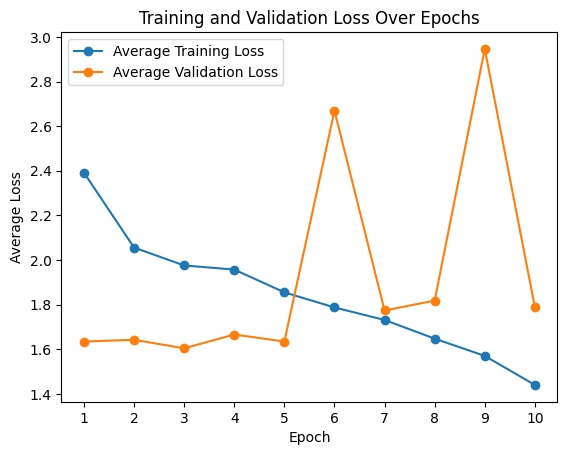

Testing Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Label:  tensor([1.3330, 0.0000], device='cuda:0')
Output:  tensor([2.3125, 2.0938], device='cuda:0')
Label:  tensor([2.0000, 2.3330], device='cuda:0')
Output:  tensor([1.7188, 2.1562], device='cuda:0')
Label:  tensor([2.3330, 2.0000], device='cuda:0')
Output:  tensor([2.2031, 2.0938], device='cuda:0')
Label:  tensor([3.6670, 2.6670], device='cuda:0')
Output:  tensor([2.1562, 2.8906], device='cuda:0')
Label:  tensor([4.6670, 2.0000], device='cuda:0')
Output:  tensor([2.6250, 2.1406], device='cuda:0')
Label:  tensor([2.3330, 1.0000], device='cuda:0')
Output:  tensor([5.0938, 2.6562], device='cuda:0')
Label:  tensor([3., 4.], device='cuda:0')
Output:  tensor([1.8828, 2.0781], device='cuda:0')
Label:  tensor([3.6670, 3.3330], device='cuda:0')
Output:  tensor([1.7734, 3.2031], device='cuda:0')
Label:  tensor([1.6670, 5.3330], device='cuda:0')
Output:  tensor([2.0938, 2.1562], device='cuda:0')
Label:  tensor([3.0000, 3.3330], device='cuda:0')
Output:  tensor([2.0781, 2.4219], device='cuda:0'

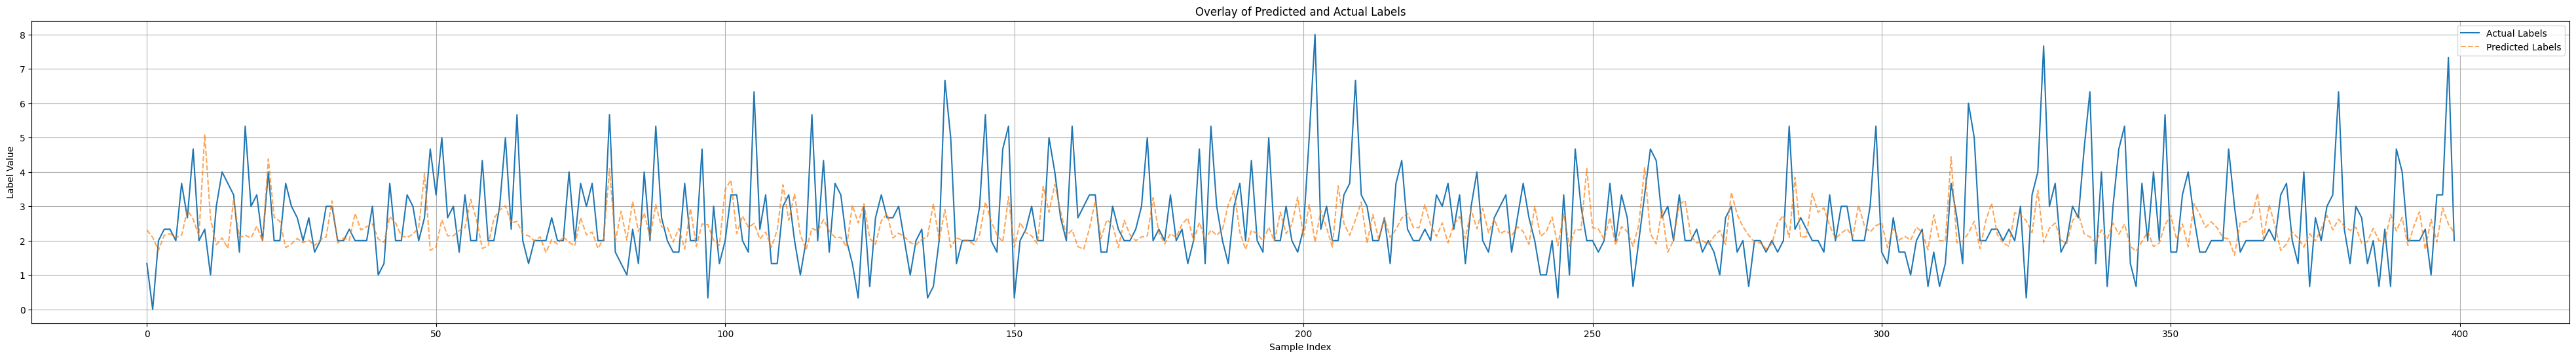

[2.3125, 2.09375, 1.71875, 2.15625, 2.203125, 2.09375, 2.15625, 2.890625, 2.625, 2.140625, 5.09375, 2.65625, 1.8828125, 2.078125, 1.7734375, 3.203125, 2.09375, 2.15625, 2.078125, 2.421875, 1.9765625, 4.375, 2.6875, 2.5625, 1.796875, 1.90625, 2.0625, 1.9453125, 2.015625, 1.8515625, 2.03125, 2.109375, 3.15625, 1.9296875, 2.078125, 2.015625, 2.796875, 2.3125, 2.40625, 2.484375, 2.046875, 1.953125, 2.703125, 2.515625, 2.140625, 2.09375, 2.1875, 2.375, 3.953125, 1.71875, 1.8203125, 2.609375, 2.140625, 2.140625, 2.296875, 2.375, 3.203125, 2.609375, 1.7734375, 1.8515625, 2.640625, 2.890625, 3.015625, 2.515625, 2.5625, 2.1875, 2.140625, 2.0, 2.109375, 1.65625, 2.03125, 1.8984375, 2.109375, 1.953125, 1.8515625, 2.671875, 2.171875, 2.25, 1.7734375, 2.0625, 4.09375, 1.96875, 2.859375, 2.015625, 3.140625, 2.265625, 2.8125, 2.09375, 3.046875, 2.40625, 2.390625, 1.9609375, 2.359375, 1.7578125, 2.9375, 1.828125, 2.484375, 2.46875, 2.015625, 1.8671875, 3.484375, 3.765625, 2.203125, 2.71875, 2.390625, 

Training Progress:   0%|          | 0/800 [00:00<?, ?it/s]

Epoch: 1, Index: 0, Loss: 6.5469
Epoch: 1, Index: 1, Loss: 1.2662
Epoch: 1, Index: 2, Loss: 11.2783
Epoch: 1, Index: 3, Loss: 5.0245
Epoch: 1, Index: 4, Loss: 8.4039
Epoch: 1, Index: 5, Loss: 4.3473
Epoch: 1, Index: 6, Loss: 1.9658
Epoch: 1, Index: 7, Loss: 0.0856
Epoch: 1, Index: 8, Loss: 3.3466
Epoch: 1, Index: 9, Loss: 0.0510
Epoch: 1, Index: 10, Loss: 0.1058
Epoch: 1, Index: 11, Loss: 4.0133
Epoch: 1, Index: 12, Loss: 0.5962
Epoch: 1, Index: 13, Loss: 0.8748
Epoch: 1, Index: 14, Loss: 0.3061
Epoch: 1, Index: 15, Loss: 2.5114
Epoch: 1, Index: 16, Loss: 2.4200
Epoch: 1, Index: 17, Loss: 1.9735
Epoch: 1, Index: 18, Loss: 7.1749
Epoch: 1, Index: 19, Loss: 0.7911
Epoch: 1, Index: 20, Loss: 1.5569
Epoch: 1, Index: 21, Loss: 9.6701
Epoch: 1, Index: 22, Loss: 1.2492
Epoch: 1, Index: 23, Loss: 1.2540
Epoch: 1, Index: 24, Loss: 1.8147
Epoch: 1, Index: 25, Loss: 5.3072
Epoch: 1, Index: 26, Loss: 0.7179
Epoch: 1, Index: 27, Loss: 17.4415
Epoch: 1, Index: 28, Loss: 1.6309
Epoch: 1, Index: 29, L

In [ ]:

total_avg_test_loss = 0
total_rmse = 0
total_mse = 0
total_mae = 0
total_r2 = 0
total_tts = 0
total_accuracy = 0
total_precision = 0
total_recall = 0
total_f1 = 0

for i in range(k_folds):
    print(f'FOLD {i + 1}')
    print('--------------------------------')
    test_indices = dataloaders[i]
    train_indices = []
    for j in range(k_folds):
        if j != i:
            train_indices += dataloaders[j]
    
    trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=10)
    testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=True, num_workers=10)
    
    trainloader = fabric.setup_dataloaders(trainloader)
    testloader = fabric.setup_dataloaders(testloader)
    
    # Reinitialize model
    
    model = GmiSwinTransformer(hidden_size=hidden_size)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    model, optimizer = fabric.setup(model, optimizer)
    model.train()
    
    # Training the model
    n_total_steps = len(trainloader)
    avg_train_loss_over_epochs = []
    avg_val_loss_over_epochs = []

    for epoch in range(num_epochs):
        train_losses = []
        val_losses = []
        
        # Training loop
        model.train()
        for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
            # Move images and labels to device
            images = images.float()
            # images = images.permute(1, 0, 2, 3, 4)  # Change shape to [5, 10, 1, 224, 224]
            labels = labels.float()

            # Forward pass with autograd
            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

            # Backward pass and optimization
            optimizer.zero_grad()
            fabric.backward(loss)
            optimizer.step()
            # Store the loss
            train_losses.append(loss.item())
        
        # Store the average training loss for this epoch
        avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
        print("Average Training Loss: ", sum(train_losses) / len(train_losses))
        
        # Validation loop
        model.eval()
        with torch.no_grad():
            for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                images = images.float()
                # images = images.permute(1, 0, 2, 3, 4)
                labels = labels.float()
                outputs = model(images).squeeze(1)
                loss = criterion(outputs, labels)
                # print("Validation Loss: ", loss.item())
                val_losses.append(loss.item())
        
        # Store the average validation loss for this epoch
        avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
        print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

    # Plot loss over epochs
    plt.figure()
    plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
    plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
    plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.legend()
    plt.title('Training and Validation Loss Over Epochs')
    plt.show()
    
    test_losses = []
    all_labels = []
    all_outputs = []

    with torch.no_grad():
        for images, labels in tqdm(testloader, desc="Testing Progress"):
            images = images.float()
            # images = images.permute(1, 0, 2, 3, 4)
            labels = labels.float()
            # print("Label: ", labels)
            outputs = model(images).squeeze(1)
            # print("Output: ", outputs)
            loss = criterion(outputs, labels)
            test_losses.append(loss.item())
            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(outputs.cpu().numpy())

    avg_test_loss = sum(test_losses) / len(test_losses)
    rmse = math.sqrt(avg_test_loss)
    mse = mean_squared_error(all_labels, all_outputs)
    mae = mean_absolute_error(all_labels, all_outputs)
    r2 = r2_score(all_labels, all_outputs)
    tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
    accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
    tts = true_skill_score(tp, tn, fp, fn)
    
    
    
    # Accumulate metrics for averaging across folds
    total_avg_test_loss += avg_test_loss
    total_rmse += rmse
    total_mse += mse
    total_mae += mae
    total_r2 += r2
    total_tts += tts
    total_accuracy += accuracy
    total_precision += precision
    total_recall += recall
    total_f1 += f1
    
    

    print(f'Average test loss: {avg_test_loss:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'MSE: {mse:.4f}')
    print(f'MAE: {mae:.4f}')
    print(f'R²: {r2:.4f}')
    print(f'True Skill Score: {tts:.4f}')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    
    plt.figure(figsize=(50, 6))

    plt.plot(all_labels, '-', label='Actual Labels')
    plt.plot(all_outputs, '--', label='Predicted Labels', alpha=0.7)

    plt.xlabel('Sample Index')
    plt.ylabel('Label Value')
    plt.title('Overlay of Predicted and Actual Labels')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(all_outputs)
    
# Average metrics across all folds
total_avg_test_loss /= k_folds
total_rmse /= k_folds
total_mse /= k_folds
total_mae /= k_folds
total_r2 /= k_folds
total_tts /= k_folds
total_accuracy /= k_folds
total_precision /= k_folds
total_recall /= k_folds
total_f1 /= k_folds

print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
print(f'Average RMSE across all folds: {total_rmse:.4f}')
print(f'Average MSE across all folds: {total_mse:.4f}')
print(f'Average MAE across all folds: {total_mae:.4f}')
print(f'Average R² across all folds: {total_r2:.4f}')
print(f'Average True Skill Score across all folds: {total_tts:.4f}')
print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
print(f'Average Precision across all folds: {total_precision:.4f}')
print(f'Average Recall across all folds: {total_recall:.4f}')
print(f'Average F1 Score across all folds: {total_f1:.4f}')


    